In [3]:
"""
character-level vanilla rnn model
"""
import numpy as np

np.random.seed(42)

# input data
data = open('one_digit_plus.txt').read()
#data = open('multi_digit_plus.txt').read()
chars = list(set(data))
nc = len(chars) # num of characters

# params
r = 0.01 # learning rate
hn = 10 # num of hidden nodes
ufdl =14 # unfolding length
Whx = np.random.randn(hn, nc)
Whh = np.random.randn(hn, hn)
Wkh = np.random.randn(nc, hn)
Bh = np.zeros([hn, 1])
Bk = np.zeros([nc, 1])
    

# define sigmoid function
sigmoid = lambda x: 1.0 / (1.0 + np.exp(-x))
softmax = lambda x: np.exp(x) / np.sum(np.exp(x))

# input a seq of chars return one-hot matrix
def onehot(data):
    m = []
    for j in range(0, len(data)):
        x = np.zeros([nc, 1])
        for i in range(0, nc):
            if chars[i] == data[j]:
                x[i] = 1
        if j == 0:
            m = x
        else:
            m = np.concatenate((m, x), axis = 1) # each colomun is a one-hot vector
    return m

# input a length ufdl pair data, e.x. idata = data[0:ufdl], odata = data[1:ufdl+1]
def update(xdata, zdata, ufdl, prevh, Whx, Whh, Wkh, Bh, Bk):
    xd = onehot(xdata)
    zd = onehot(zdata)
    
    dWhx, dWhh, dWkh, dBh, dBk = np.zeros_like(Whx), np.zeros_like(Whh), np.zeros_like(Wkh), np.zeros_like(Bh), np.zeros_like(Bk)
    Ykt, Aht, Yht, dKt, dHt = {},{},{},{},{} 
    loss = 0
    
    # forward pass
    for t in range(0, ufdl):
        Xt = xd[:, t]
        Xt = Xt.reshape([len(Xt), 1])
        Zt = zd[:, t]
        Zt = Zt.reshape([len(Zt), 1])
        Aht[t] = Whx.dot(Xt) + Whh.dot(prevh) + Bh
        Yht[t] = sigmoid(Aht[t])
        prevh = Yht[t]
        Akt = Wkh.dot(Yht[t]) + Bk
        Ykt[t] = softmax(Akt)
        loss = loss - np.sum(Zt * np.log(Ykt[t]))

    # backward pass
    dhp1 = np.zeros_like(Aht[0])
    Yht[-1] = np.zeros_like(Yht[0])
    for t in np.arange(ufdl, 0, -1)-1:
        Xt = xd[:, t]
        Xt = Xt.reshape([len(Xt), 1])
        Zt = zd[:, t]
        Zt = Zt.reshape([len(Zt), 1])
        dKt = Ykt[t] - Zt
        dWkh = dWkh + dKt.dot(np.transpose(Yht[t]))
        dBk = dBk + dKt
        
        dHt = sigmoid(Aht[t])*(1-sigmoid(Aht[t]))*( np.transpose(Wkh).dot(dKt)+np.transpose(Whh).dot(dhp1) ) 

        dWhx = dWhx + dHt.dot(np.transpose(Xt))
        dWhh = dWhh + dHt.dot(np.transpose(Yht[t-1]))
  #      print 't = %d, %f'%(t, np.max(np.linalg.norm(dHt.dot(np.transpose(Yht[t-1])))) )

        dBh = dBh + dHt
        dhp1 = dHt
    return Yht[ufdl-1], dWhx, dWhh, dWkh, dBh, dBk, loss

def sample(sc, steps, prevh, Whx, Whh, Wkh, Bh, Bk): # sc: starting character
    Xt = onehot(sc)
    output = sc
    for t in range(steps):
        Aht = Whx.dot(Xt) + Whh.dot(prevh) + Bh
        Yht = sigmoid(Aht)
        prevh = Yht
        Akt = Wkh.dot(Yht) + Bk
        Ykt = softmax(Akt)
        idx = np.random.choice(nc, p=Ykt.reshape([len(Ykt)]))
        output += chars[idx]        
        Xt = np.zeros_like(Xt)
        Xt[idx] = 1
    print output
    
tlength = len(data)
prevh = np.zeros([hn, 1]) # prev state 

for p in range(80):
    L, pt = 0, 0
    for j in range( tlength / ufdl - 1 ):
        prevh, dWhx, dWhh, dWkh, dBh, dBk, loss = update(data[pt: pt+ufdl], data[pt+1: pt+ufdl+1], ufdl, prevh, Whx, Whh, Wkh, Bh, Bk)
        
        Whx -= r*dWhx
        Whh -= r*dWhh
        Wkh -= r*dWkh
        Bh -= r*dBh
        Bk -= r*dBk
        pt = pt + ufdl
        L += loss
#    print L


In [11]:
def sample_firing(sc, steps, prevh, Whx, Whh, Wkh, Bh, Bk): # sc: starting character
    Xt = onehot(sc)
    output = sc
    hf = np.zeros([hn, steps])
    
    for t in range(steps):
        Aht = Whx.dot(Xt) + Whh.dot(prevh) + Bh
        Yht = sigmoid(Aht)
        prevh = Yht
        
        hf[ :, t] = Yht.reshape([hn])
        
        Akt = Wkh.dot(Yht) + Bk
        Ykt = softmax(Akt)
        idx = np.random.choice(nc, p=Ykt.reshape([len(Ykt)]))
        output += chars[idx]        
        Xt = np.zeros_like(Xt)
        Xt[idx] = 1
    return output, hf

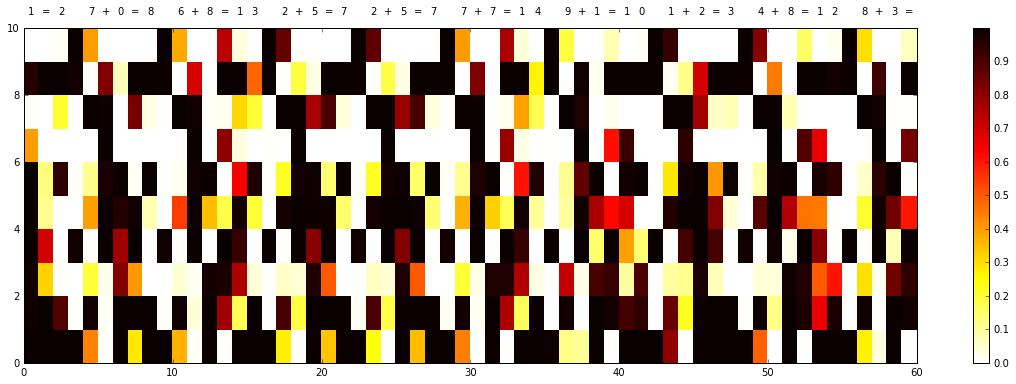

In [12]:
import matplotlib.pyplot as plt
%matplotlib inline
np.random.seed(42)

steps =60
output, hf = sample_firing('1', steps, prevh, Whx, Whh, Wkh, Bh, Bk)


fig = plt.figure(figsize=(20,6))
heatmap = plt.pcolor(hf,cmap='hot_r')

y = hn
for x in range(hf.shape[1]):
    plt.text(x + 0.5, y + 0.5, '%s'% output[x] ,
        horizontalalignment='center',
        verticalalignment='center',
        )
    
plt.colorbar(heatmap)

plt.show()

The above figure shows the encoding relation between input and hidden neuron's firing rates. The figure is generated in the sampling step. The input are on top of the firgure. Each row is a hidden neuron's output corresponding to the input above. We note the following:
- some neurons specificly fire when inputs are operators or space or some particular position (#10, 7)
- some neurons specificly not to fire for specific thing (#5)
- the repitition "2+5=7" in the middle has exact same firing pattern for every neuron
- whenever the input is space, the network has exact same firing pattern
- whenever the input is "+", the network has very similar but not exact same firing patterns
- same digits has similar firing pattern if they are in the same "position" (ex. "8")

In [55]:
def sample_dist(l, sc, steps, prevh, Whx, Whh, Wkh, Bh, Bk): # sc: starting character
    Xt = onehot(sc)
    output = sc
    hf = np.zeros([l, steps])
    hc = np.chararray([l, steps])
    for t in range(steps):
        Aht = Whx.dot(Xt) + Whh.dot(prevh) + Bh
        Yht = sigmoid(Aht)
        prevh = Yht
        
        Akt = Wkh.dot(Yht) + Bk
        Ykt = softmax(Akt)
     
        sortidx = np.argsort(np.ravel(-Ykt))

        hf[:, t] = Ykt[sortidx[0:l]].reshape(l)
        
        for n in range(l):
            hc[n, t] = chars[sortidx[n]] 
        
        idx = np.random.choice(nc, p=Ykt.reshape([len(Ykt)]))
        output += chars[idx]        
        Xt = np.zeros_like(Xt)
        Xt[idx] = 1
    return output, hf, hc



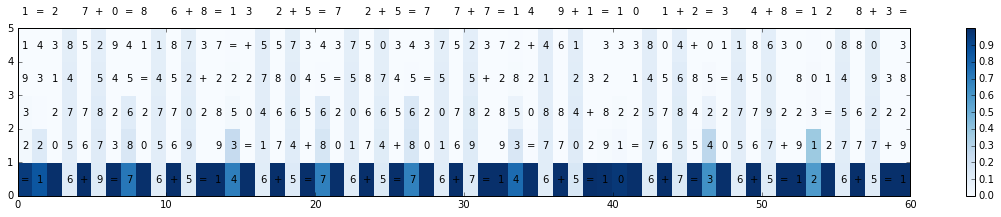

In [56]:

np.random.seed(42)

steps =60
numlargest = 5

output, hf, hc = sample_dist(numlargest, '1', steps, prevh, Whx, Whh, Wkh, Bh, Bk)

fig = plt.figure(figsize=(20,3))
heatmap = plt.pcolor(hf,cmap=plt.cm.Blues)


y = numlargest
for x in range(hf.shape[1]):
    plt.text(x + 0.5, y + 0.5, '%s'% output[x] ,
        horizontalalignment='center',
        verticalalignment='center',
        )

for x in range(hf.shape[1]):
    for y in range(hf.shape[0]):
        plt.text(x + 0.5, y + 0.5, '%s'% hc[y,x] ,
            horizontalalignment='center',
            verticalalignment='center',
            )
    
plt.colorbar(heatmap)

plt.show()

The above figure top first 5 guesses of the network given current input on the top.